In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, auc, roc_curve, f1_score
import dask_ml as dml
import dask_ml.model_selection as dcv
from dask.diagnostics import ProgressBar

import warnings
warnings.simplefilter('always', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('clean_merged_data.csv')
del df['Unnamed: 0']
modeling_data = df[[
    'offer_id', 
    'offer_type',
    'duration',
    'offer_reward',
    'difficulty',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'gender', 
    'age',  
    'income',
    'membership_days',
    'membership_month', 
    'membership_year',
    'successful_offer'   
        ]]
df.head()

person         offer_id  original_reward  time_received  duration  \
0    user_100        bogo_7_10              0.0          336.0       7.0   
1    user_100    discount_10_5              0.0            0.0      10.0   
2    user_100    discount_10_5              0.0          576.0      10.0   
3    user_100  informational_4              0.0          408.0       4.0   
4  user_10002  informational_4              0.0          336.0       4.0   

   time_viewed  time_completed  expiray_time  successful_offer  tried_offer  \
0          NaN             NaN         343.0                 0            0   
1          NaN             NaN          10.0                 0            0   
2          NaN             NaN         586.0                 0            0   
3          NaN             NaN         412.0                 0            0   
4          NaN             NaN         340.0                 0            0   

   ... membership_month  membership_year channel_email  channel_mobile  \
0  ...              7.0           2016.0             1               1   
1  ...              7.0           2016.0             1               0   
2  ...              7.0           2016.0             1               0   
3  ...              7.0           2016.0             1               1   
4  ...             11.0           2015.0             1               1   

   channel_social  channel_web  difficulty     offer_type  offer_reward  \
0               1            0          10           bogo            10   
1               0            1          20       discount             5   
2               0            1          20       discount             5   
3               0            1           0  informational             0   
4               0            1           0  informational             0   

   num_channels  
0             3  
1             2  
2             2  
3             3  
4             3  

[5 rows x 25 columns]

In [4]:
cont_vars = [
    'duration',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'age',  
    'income',
    'membership_days'
]

cat_vars = [
    'offer_id',
    'offer_type',
    'offer_reward',
    'difficulty',
    'gender', 
    'membership_month', 
    'membership_year'
]

features = cont_vars+cat_vars

y_var = 'successful_offer'

In [5]:
for i in cat_vars:
    modeling_data.loc[:, i] = modeling_data[i].astype('category')

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [6]:
features

['duration',
 'num_channels',
 'channel_email',
 'channel_mobile',
 'channel_social',
 'channel_web',
 'age',
 'income',
 'membership_days',
 'offer_id',
 'offer_type',
 'offer_reward',
 'difficulty',
 'gender',
 'membership_month',
 'membership_year']

In [7]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb


In [8]:
Y = modeling_data[y_var].astype(str)
train_val_df, test_df = train_test_split(modeling_data, test_size=0.2, random_state=2021, stratify = Y)
Y = train_val_df[y_var].astype(str)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=2021, stratify = Y)


train_data = lgb.Dataset(train_df[features], label=train_df[y_var],free_raw_data=False)
val_data = lgb.Dataset(val_df[features], label=val_df[y_var],free_raw_data=False)
test_data = lgb.Dataset(test_df[features], label=test_df[y_var], free_raw_data=False)


scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)
(len(test_df)-sum(test_df[y_var]))/sum(test_df[y_var])

37.538128249566725


37.608333333333334

In [8]:
import itertools
def plot_confusion_matrix(cm, cmap=plt.cm.BuGn):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title='Confusion matrix'
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 15)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks([-0.5,1.5], [0,1], rotation=0)
#     plt.yticks(tick_marks, [0,1])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 15)
    plt.xlabel('Predicted label', fontsize = 15)

In [9]:
def perf_analysis(model, data, features, y_var, which_data = 'Train Set'):
    print('**************', 'Performance:', which_data, '****************', '\n')
    
    
    y_pred = model.predict(data[features])
    y_pred = y_pred.round(0)
    cnf_matrix = confusion_matrix(data[y_var], y_pred)
    plot_confusion_matrix(cnf_matrix)

    
    print("Accuracy:", round(accuracy_score(data[y_var], y_pred),2))
    print("Precision:", round(precision_score(data[y_var], y_pred),2))
    print("Recall:", round(recall_score(data[y_var], y_pred),2))
    print("F1:", round(f1_score(data[y_var], y_pred),2))

#     fpr, tpr, thresholds = roc_curve(data[y_var], model.predict_proba(data[features])[:, 1])
    
    fpr, tpr, thresholds = roc_curve(data[y_var], model.predict(data[features]))
    
    
    roc_auc = auc(fpr,tpr)

    # Plot ROC
    plt.figure(figsize = (8,6))
    plt.title(which_data+': ROC', fontsize = 15)
    plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
    plt.legend(loc='lower right', fontsize =15)
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.show()

In [26]:
# mc = [1 for f in cont_vars]+[None for f in cat_vars]


params = {'objective': "binary", 'metric': ['binary_logloss', 'binary_error'], 'num_threads':-1, 'seed':2021, 'verbose': -1,
              
              'max_depth':5, 
              'num_leaves':10, 
              'learning_rate': 0.2,
              'num_iterations':1000,
              'min_data_in_leaf': 300,
              'max_bin':100,
          'scale_pos_weight':scale_pos_weight_val
#          'monotone_constraints': mc
         }

gbm_model = lgb.train(params,
            train_data,
            valid_sets=[val_data],
            feature_name=features,
            categorical_feature=cat_vars,
            verbose_eval=-1,
            early_stopping_rounds=400, )

/opt/cortex-installs/miniconda/envs/cortex-python3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/cortex-installs/miniconda/envs/cortex-python3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/cortex-installs/miniconda/envs/cortex-python3/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['difficulty', 'gender', 'membership_month', 'membership_year', 'offer_id', 'offer_reward', 'offer_type']
  _log_warning('categorical_feature in Datas

Training until validation scores don't improve for 400 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.306056	valid_0's binary_error: 0.130767


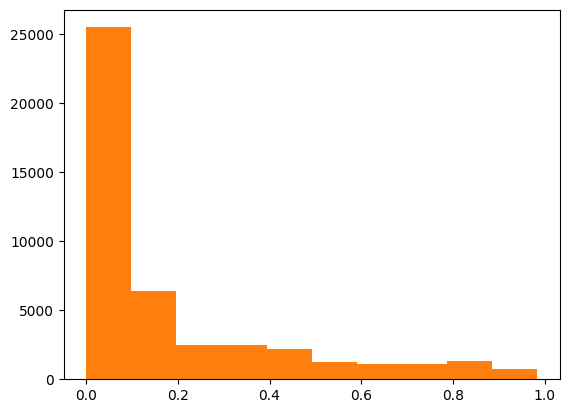

In [30]:
y_preds = gbm_model.predict(train_df[features])
plt.hist(y_preds)
plt.show()

************** Performance: Train Set **************** 

Accuracy: 0.9
Precision: 0.21
Recall: 0.97
F1: 0.34


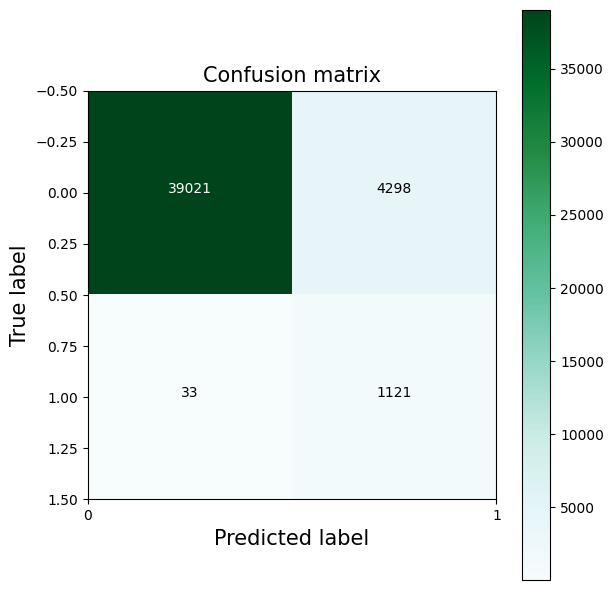

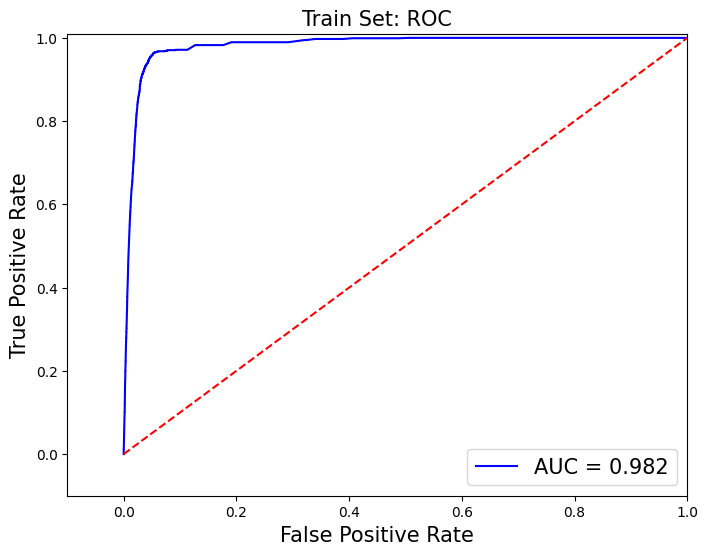

************** Performance: Test Set **************** 

Accuracy: 0.87
Precision: 0.07
Recall: 0.29
F1: 0.11


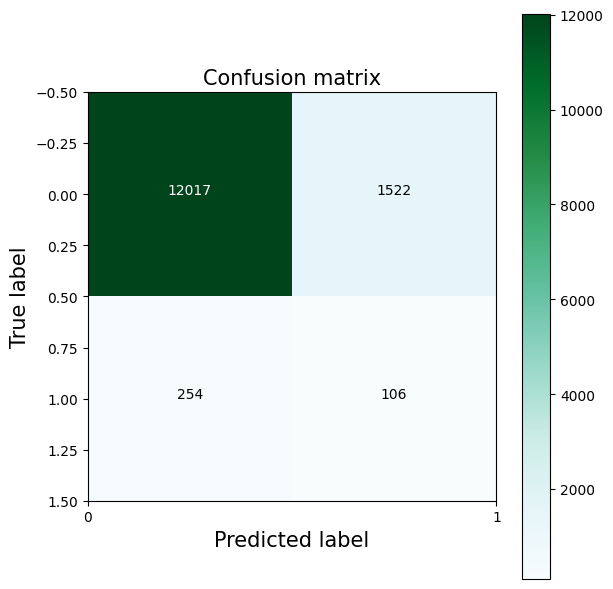

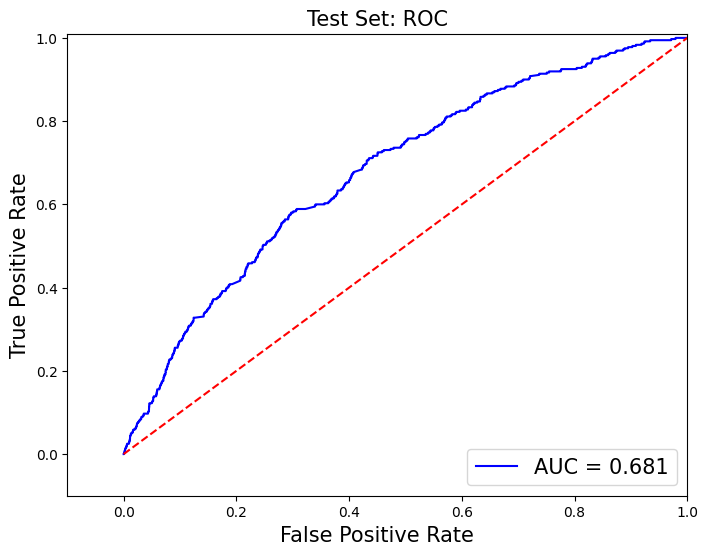

In [31]:
perf_analysis(model = gbm_model, data = train_df, features = features, y_var = y_var, which_data = 'Train Set')
perf_analysis(model = gbm_model, data = test_df, features = features, y_var = y_var, which_data = 'Test Set')

In [13]:
Y = modeling_data[y_var].astype(str)
train_df, test_df = train_test_split(modeling_data, test_size=0.2, random_state=2021, stratify = Y)


scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)
(len(test_df)-sum(test_df[y_var]))/sum(test_df[y_var])

37.552011095700415


37.608333333333334

In [33]:
param_test ={'max_depth':[3,5,8,10],
    'num_leaves': [5,10,20, 30, 40], 
             'min_child_samples': [200, 400], 
             'reg_alpha': [0, 1e-2, 1e-1, 1],
             'reg_lambda': [0, 1e-2, 1e-1, 1],
             'scale_pos_weight': [scale_pos_weight_val]
            }

In [39]:
gbm_model = lgb.LGBMClassifier(objective = "binary", metric = ['auc', 'binary_error'], random_state=2021, verbose=-1, n_jobs=-1, n_estimators=1000)
gbm_gs = dcv.GridSearchCV(
    estimator=gbm_model, param_grid=param_test, 
    scoring='f1',
    cv=5,
    refit=True,
)

In [40]:
with ProgressBar():
    gbm_gs.fit(train_df[features], train_df[y_var])

[########################################] | 100% Completed |  4hr 55min 39.7s
[########################################] | 100% Completed |  1min 20.4s


In [41]:
print('Best score reached: {} with params: {} '.format(gbm_gs.best_score_, gbm_gs.best_params_))

Best score reached: 0.11354662934428611 with params: {'max_depth': 5, 'min_child_samples': 200, 'num_leaves': 10, 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 37.552011095700415} 


In [ ]:
# Best score reached: 0.11354662934428611 with params: 
# {'max_depth': 5, 'min_child_samples': 200, 'num_leaves': 10, 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 37.552011095700415} 

In [42]:
y_train_pred = gbm_gs.predict(train_df[features])
y_train_pred = y_train_pred.round(0)
cnf_matrix_train = confusion_matrix(train_df[y_var], y_train_pred)
plot_confusion_matrix(cnf_matrix_train)

In [43]:
print('Performance: Train set \n')
print("Accuracy:", round(accuracy_score(train_df[y_var], y_train_pred),2))
print("Precision:", round(precision_score(train_df[y_var], y_train_pred),2))
print("Recall:", round(recall_score(train_df[y_var], y_train_pred),2))
print("F1:", round(f1_score(train_df[y_var], y_train_pred),2))

Performance: Train set 

Accuracy: 0.83
Precision: 0.13
Recall: 0.96
F1: 0.22


In [44]:
y_test_pred = gbm_gs.predict(test_df[features])
y_test_pred = y_test_pred.round(0)
cnf_matrix = confusion_matrix(test_df[y_var], y_test_pred)
plot_confusion_matrix(cnf_matrix)

In [45]:
print('Performance: Test set \n')
print("Accuracy:", round(accuracy_score(test_df[y_var], y_test_pred),2))
print("Precision:", round(precision_score(test_df[y_var], y_test_pred), 2))
print("Recall:", round(recall_score(test_df[y_var], y_test_pred),2))
print("F1:", round(f1_score(test_df[y_var], y_test_pred),2))

Performance: Test set 

Accuracy: 0.8
Precision: 0.06
Recall: 0.46
F1: 0.11


In [14]:
# {'max_depth': 5, 'min_child_samples': 200, 'num_leaves': 10, 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 37.552011095700415} 
param_test ={'max_depth':[5],
    'num_leaves': [10], 
             'min_child_samples': [200], 
             'reg_alpha': [0.01],
             'reg_lambda': [1],
             'scale_pos_weight': [37.552011095700415],
             'learning_rate':[0.001, 0.01, 0.05, 0.1, 0.2]

            }

In [15]:
gbm_model = lgb.LGBMClassifier(objective = "binary", metric = ['auc', 'binary_error'], random_state=2021, verbose=-1, n_jobs=-1, n_estimators=1000)
gbm_gs = dcv.GridSearchCV(
    estimator=gbm_model, param_grid=param_test, 
    scoring='f1',
    cv=5,
    refit=True,
)

In [16]:
with ProgressBar():
    gbm_gs.fit(train_df[features], train_df[y_var])

[########################################] | 100% Completed |  1min 58.3s
[########################################] | 100% Completed |  8.0s


In [17]:
print('Best score reached: {} with params: {} '.format(gbm_gs.best_score_, gbm_gs.best_params_))

Best score reached: 0.11354662934428611 with params: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 200, 'num_leaves': 10, 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 37.552011095700415} 


In [ ]:
# Best score reached: 0.11354662934428611 with params: 
# {'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 200, 'num_leaves': 10, 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 37.552011095700415} 

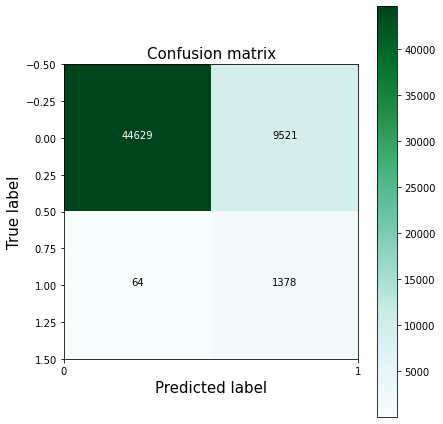

In [18]:
y_train_pred = gbm_gs.predict(train_df[features])
y_train_pred = y_train_pred.round(0)
cnf_matrix_train = confusion_matrix(train_df[y_var], y_train_pred)
plot_confusion_matrix(cnf_matrix_train)

In [19]:
print('Performance: Train set \n')
print("Accuracy:", round(accuracy_score(train_df[y_var], y_train_pred),2))
print("Precision:", round(precision_score(train_df[y_var], y_train_pred),2))
print("Recall:", round(recall_score(train_df[y_var], y_train_pred),2))
print("F1:", round(f1_score(train_df[y_var], y_train_pred),2))

Performance: Train set 

Accuracy: 0.83
Precision: 0.13
Recall: 0.96
F1: 0.22


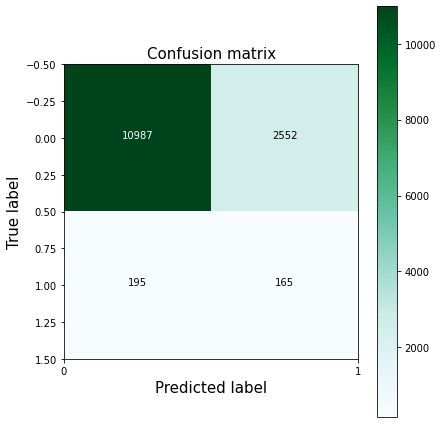

In [20]:
y_test_pred = gbm_gs.predict(test_df[features])
y_test_pred = y_test_pred.round(0)
cnf_matrix = confusion_matrix(test_df[y_var], y_test_pred)
plot_confusion_matrix(cnf_matrix)

In [21]:
print('Performance: Test set \n')
print("Accuracy:", round(accuracy_score(test_df[y_var], y_test_pred),2))
print("Precision:", round(precision_score(test_df[y_var], y_test_pred), 2))
print("Recall:", round(recall_score(test_df[y_var], y_test_pred),2))
print("F1:", round(f1_score(test_df[y_var], y_test_pred),2))

Performance: Test set 

Accuracy: 0.8
Precision: 0.06
Recall: 0.46
F1: 0.11


In [10]:
Y = modeling_data[y_var].astype(str)
train_df, test_df = train_test_split(modeling_data, test_size=0.2, random_state=2021, stratify = Y)


scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)
(len(test_df)-sum(test_df[y_var]))/sum(test_df[y_var])

train_data = lgb.Dataset(train_df[features], label=train_df[y_var],free_raw_data=False)
test_data = lgb.Dataset(test_df[features], label=test_df[y_var], free_raw_data=False)

37.552011095700415


In [11]:
# mc = [1 for f in cont_vars]+[None for f in cat_vars]
# {'max_depth': 5, 'min_child_samples': 200, 'num_leaves': 10, 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 37.552011095700415} 

params = {'objective': "binary", 'metric': ['auc', 'binary_error'], 'num_threads':-1, 'seed':2021, 'verbose': -1,
          'max_depth': 5, 
          'min_child_samples': 200, 
          'num_leaves': 10, 
          'reg_alpha': 0.01, 
          'reg_lambda': 1, 
          'scale_pos_weight': 37.552011095700415,
          'n_estimators': 1000,
#           'feature_fraction':0.8
#           'bagging_freq': 10,
#           'bagging_fraction': 0.8
#           'learning_rate': 0.1
#          'monotone_constraints': mc
         }

gbm_model = lgb.train(params,
            train_data,
            valid_sets=[train_data],
            feature_name=features,
            categorical_feature=cat_vars,
            verbose_eval=-1,
            early_stopping_rounds=400,
                     )

C:\Program Files\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Program Files\Anaconda3\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['difficulty', 'gender', 'membership_month', 'membership_year', 'offer_id', 'offer_reward', 'offer_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 400 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.951649	training's binary_error: 0.172417


************** Performance: Train Set **************** 

Accuracy: 0.83
Precision: 0.13
Recall: 0.96
F1: 0.22


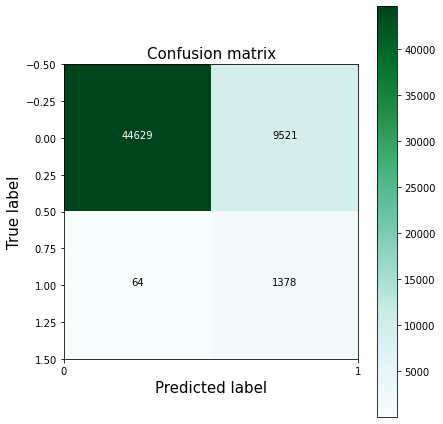

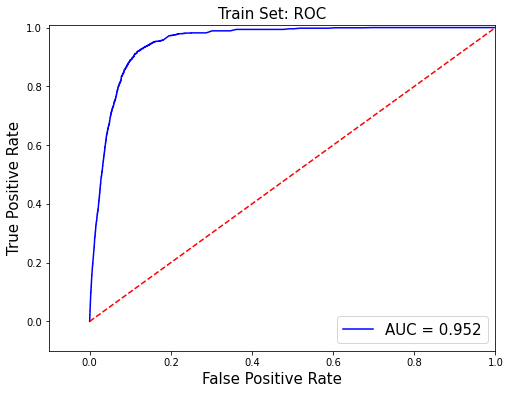

************** Performance: Test Set **************** 

Accuracy: 0.8
Precision: 0.06
Recall: 0.46
F1: 0.11


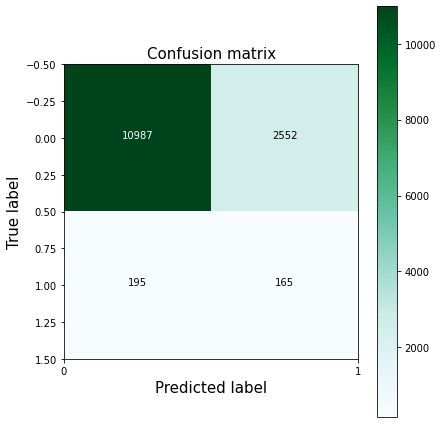

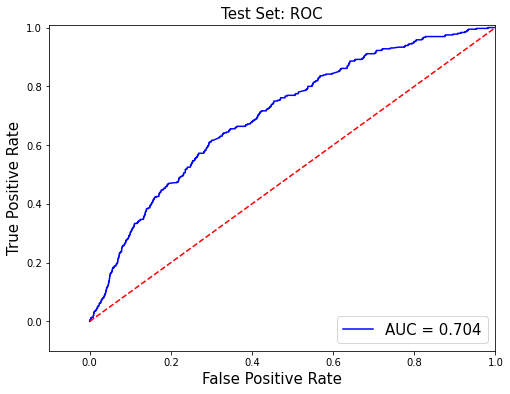

In [12]:
perf_analysis(model = gbm_model, data = train_df, features = features, y_var = y_var, which_data = 'Train Set')
perf_analysis(model = gbm_model, data = test_df, features = features, y_var = y_var, which_data = 'Test Set')

In [13]:
train_df.head()

offer_id offer_type  duration offer_reward difficulty  \
55304  discount_10_2   discount      10.0            2         10   
26483      bogo_7_10       bogo       7.0           10         10   
17963      bogo_7_10       bogo       7.0           10         10   
7101   discount_10_5   discount      10.0            5         20   
8676   discount_10_5   discount      10.0            5         20   

       num_channels  channel_email  channel_mobile  channel_social  \
55304             4              1               1               1   
26483             3              1               1               1   
17963             3              1               1               1   
7101              2              1               0               0   
8676              2              1               0               0   

       channel_web gender   age   income  membership_days membership_month  \
55304            1      F  48.0  63000.0           1652.0              5.0   
26483            0      M  43.0  42000.0           1408.0              1.0   
17963            0      F  76.0  80000.0           2003.0              5.0   
7101             1      M  19.0  46000.0           2105.0              2.0   
8676             1      F  54.0  48000.0           2556.0             11.0   

      membership_year  successful_offer  
55304          2017.0                 0  
26483          2018.0                 0  
17963          2016.0                 0  
7101           2016.0                 0  
8676           2014.0                 0

In [14]:
features

['duration',
 'num_channels',
 'channel_email',
 'channel_mobile',
 'channel_social',
 'channel_web',
 'age',
 'income',
 'membership_days',
 'offer_id',
 'offer_type',
 'offer_reward',
 'difficulty',
 'gender',
 'membership_month',
 'membership_year']

In [15]:
import shap as shap
shap.initjs()

In [16]:
explainer = shap.TreeExplainer(gbm_model)
shap_values = explainer.shap_values(train_df[features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [17]:
shap.force_plot(explainer.expected_value[1], shap_values[1][:100,:], train_df[features].iloc[:100,:])


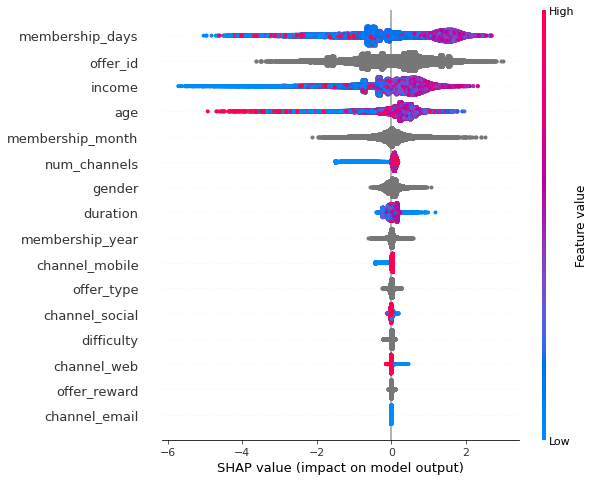

In [18]:
shap.summary_plot(shap_values[1], train_df[features], feature_names = features, max_display = 30)


In [21]:
shap.dependence_plot('income', shap_values[1], train_df[features]) #, display_features=train_df)

TypeError: '<' not supported between instances of 'float' and 'str'

In [ ]:
for name in features:
    shap.dependence_plot(name, shap_values[1], train_df[features])#, display_features=X_display)

In [50]:
name

'duration'

In [52]:
features

['duration',
 'num_channels',
 'channel_email',
 'channel_mobile',
 'channel_social',
 'channel_web',
 'age',
 'income',
 'membership_days',
 'offer_id',
 'offer_type',
 'offer_reward',
 'difficulty',
 'gender',
 'membership_month',
 'membership_year']

In [20]:
print(shap.__version__)

0.39.0


In [56]:
!pip install shap==0.39.0 --user

Looking in indexes: https://repo.forge.lmig.com/api/pypi/python/simple


You should consider upgrading via the 'c:\program files\anaconda3\python.exe -m pip install --upgrade pip' command.


In [91]:
df = pd.read_csv('./data/merged_data.csv')
del df['Unnamed: 0']
modeling_data = df[[
    'offer_id', 
    'offer_type',
    'duration',
    'offer_reward',
    'difficulty',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'gender', 
    'age',  
    'income',
    'membership_days',
    'membership_month', 
    'membership_year',
    'successful_offer'   
        ]]
df.head()

person         offer_id  original_reward  time_received  duration  \
0    user_100        bogo_7_10              0.0          336.0       7.0   
1    user_100    discount_10_5              0.0            0.0      10.0   
2    user_100    discount_10_5              0.0          576.0      10.0   
3    user_100  informational_4              0.0          408.0       4.0   
4  user_10002  informational_4              0.0          336.0       4.0   

   time_viewed  time_completed  reward  successful_offer  tried_offer  ...  \
0          NaN             NaN     NaN                 0            0  ...   
1          NaN             NaN     NaN                 0            0  ...   
2          NaN             NaN     NaN                 0            0  ...   
3          NaN             NaN     NaN                 0            0  ...   
4          NaN             NaN     NaN                 0            0  ...   

  membership_month  membership_year     offer_type  num_channels  \
0              7.0           2016.0           bogo             3   
1              7.0           2016.0       discount             2   
2              7.0           2016.0       discount             2   
3              7.0           2016.0  informational             3   
4             11.0           2015.0  informational             3   

   offer_reward  difficulty  channel_email channel_mobile  channel_social  \
0            10          10              1              1               1   
1             5          20              1              0               0   
2             5          20              1              0               0   
3             0           0              1              1               0   
4             0           0              1              1               0   

   channel_web  
0            0  
1            1  
2            1  
3            1  
4            1  

[5 rows x 25 columns]

In [92]:
cont_vars = [
    'duration',
    'num_channels',
    'channel_email', 
    'channel_mobile', 
    'channel_social', 
    'channel_web',
    'age',  
    'income',
    'membership_days',
        'difficulty',
        'membership_month', 


]

cat_vars = [
    'offer_id',
    'offer_type',
    'offer_reward',
    'gender', 
#     'membership_month', 
    'membership_year',
#     'membership_deciles'
]

features = cont_vars+cat_vars

y_var = 'successful_offer'

In [93]:
modeling_data['income_X_age'] = modeling_data['income']*modeling_data['age']


Y = modeling_data[y_var].astype(str)
train_df, test_df = train_test_split(modeling_data, test_size=0.2, random_state=2021, stratify = Y)


scale_pos_weight_val = (len(train_df)-sum(train_df[y_var]))/sum(train_df[y_var])
print(scale_pos_weight_val)
(len(test_df)-sum(test_df[y_var]))/sum(test_df[y_var])




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


33.38296349319971


33.40974212034384

In [94]:
# Find the decile cuts in the train data and apply it to the test data, to avoid data leakage
train_df.loc[:, 'membership_deciles'] = pd.qcut(train_df['membership_days'],  q = 10,  duplicates = 'drop', labels = np.arange(1,11,1))
# train_df.loc[:, 'membership_deciles'] = train_df['membership_deciles'].astype(str)
bid_cuts = train_df.groupby(['membership_deciles'])[['membership_days']].min().reset_index()
bid_cuts.columns = ['membership_deciles', 'min_val']
temp = train_df.groupby(['membership_deciles'])[['membership_days']].max().reset_index()
temp.columns = ['membership_deciles', 'max_val']
bid_cuts = bid_cuts.merge(temp, on = ['membership_deciles'])
bid_cuts['membership_deciles'] = bid_cuts['membership_deciles'].astype(int)
bid_cuts = bid_cuts.sort_values(by = ['membership_deciles']).reset_index(drop = True)

bid_cuts_list = [-1]+bid_cuts['max_val'].tolist()
bid_cuts_list[-1] = np.inf

test_df.loc[:, 'membership_deciles'] = pd.cut(test_df["membership_days"],
                                              bins=bid_cuts_list,
                                              right=True, 
                                              labels=False) + 1

test_df.loc[:, 'membership_deciles'] = test_df['membership_deciles'].astype(str)
test_df.loc[:, "membership_deciles"] = test_df["membership_deciles"].astype(str).replace('\.0', '', regex=True)

In [95]:
for i in cat_vars:
#     modeling_data.loc[:, i] = modeling_data[i].astype('category')
    train_df.loc[:, i] = train_df[i].astype('category')
    test_df.loc[:, i] = test_df[i].astype('category')

In [96]:
features = [
    'duration',
    'num_channels',
    'channel_email',
    'channel_mobile',
    'channel_social',
    'channel_web',
    'age',
    'income',
    'membership_days',
#     'membership_deciles',
    'offer_id',
    'offer_type',
    'offer_reward',
    'difficulty',
    'gender',
    'membership_month',
    'membership_year',
    'income_X_age'
]

In [97]:
train_data = lgb.Dataset(train_df[features], label=train_df[y_var],free_raw_data=False)
test_data = lgb.Dataset(test_df[features], label=test_df[y_var], free_raw_data=False)

# mc = [-1 for f in cont_vars]+[None for f in cat_vars]
# {'max_depth': 5, 'min_child_samples': 200, 'num_leaves': 10, 'reg_alpha': 0.01, 'reg_lambda': 1, 'scale_pos_weight': 37.552011095700415} 

params = {'objective': "binary", 'metric': ['auc', 'binary_error'], 'num_threads':-1, 'seed':2021, 'verbose': -1,
          'max_depth': 5, 
          'min_child_samples': 200, 
          'num_leaves': 10, 
          'reg_alpha': 0.01, 
          'reg_lambda': 1, 
          'scale_pos_weight': scale_pos_weight_val,
          'n_estimators': 1000,
#           'feature_fraction':0.8
#           'bagging_freq': 10,
#           'bagging_fraction': 0.8
#           'learning_rate': 0.1
#          'monotone_constraints': mc
         }

gbm_model = lgb.train(params,
            train_data,
            valid_sets=[train_data],
            feature_name=features,
            categorical_feature=cat_vars,
            verbose_eval=-1,
            early_stopping_rounds=400,
                     )

Found `n_estimators` in params. Will use it instead of argument
categorical_feature in Dataset is overridden.
New categorical_feature is ['gender', 'membership_year', 'offer_id', 'offer_reward', 'offer_type']


Training until validation scores don't improve for 400 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.950073	training's binary_error: 0.185831


************** Performance: Train Set **************** 

Accuracy: 0.81
Precision: 0.13
Recall: 0.98
F1: 0.23


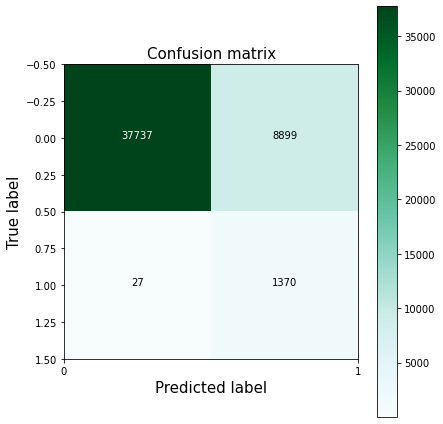

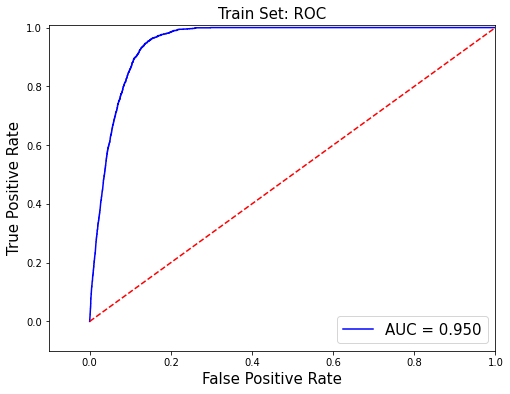

************** Performance: Test Set **************** 

Accuracy: 0.78
Precision: 0.06
Recall: 0.46
F1: 0.11


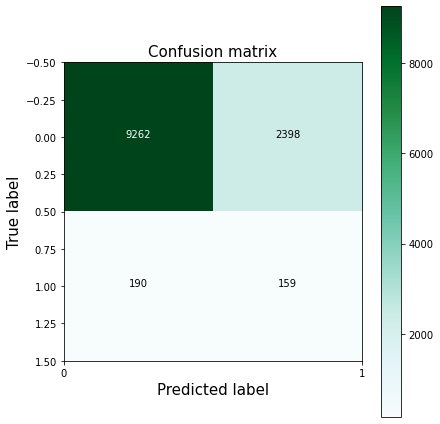

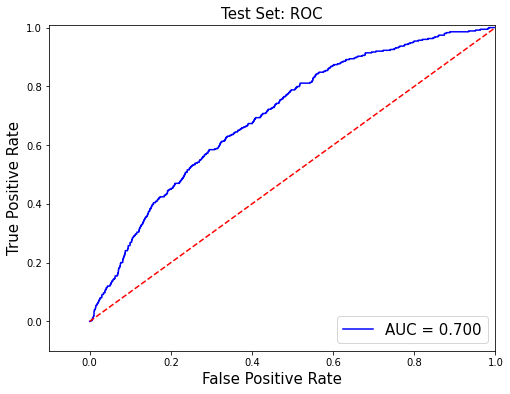

In [98]:
perf_analysis(model = gbm_model, data = train_df, features = features, y_var = y_var, which_data = 'Train Set')
perf_analysis(model = gbm_model, data = test_df, features = features, y_var = y_var, which_data = 'Test Set')

In [99]:
explainer = shap.TreeExplainer(gbm_model)
shap_values = explainer.shap_values(train_df[features])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


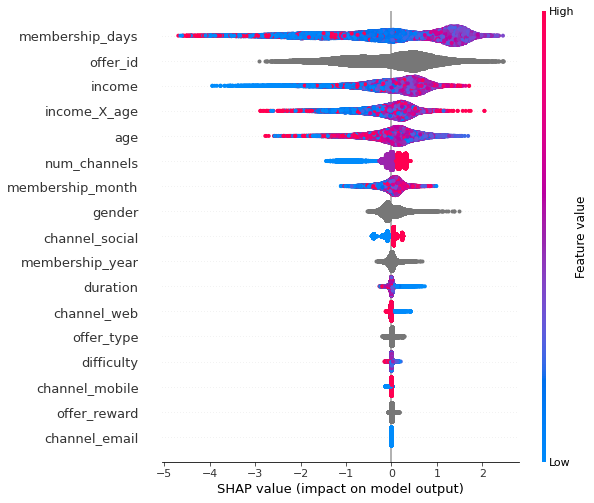

In [100]:
shap.summary_plot(shap_values[1], train_df[features], feature_names = features, max_display = 30)
